# <center> Phantom net Benchmark </center>

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import adler
adler.util.gpu.setup_one_gpu(1)

Picking GPU 1


In [3]:
from adler.odl.phantom import random_phantom as random_phantom_jonas
from adler.tensorflow import prelu, cosine_decay

In [4]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow
import math

### Data

In [5]:
import sys
sys.path.append("../../WF_inpaint/")

In [7]:
# Import the needed modules
from data.data_factory import random_realphantom, random_phantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

In [8]:
size = 256
nClasses = 180
lowd = 180
wedge = 20

In [9]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

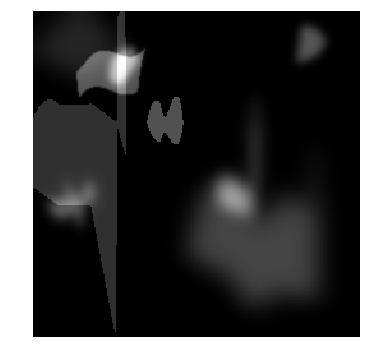

In [10]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

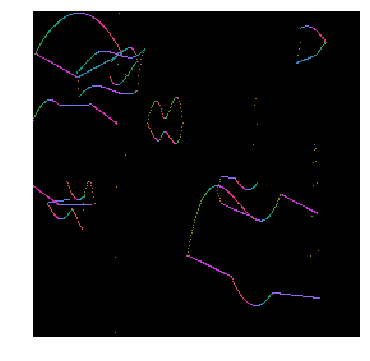

In [11]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

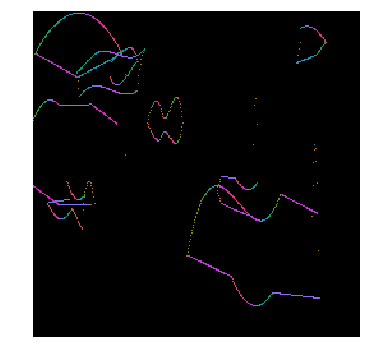

In [12]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

### Sinogram of real phantom with WFset generation with full and lowd

In [13]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [14]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [15]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [16]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [17]:
size = 256
detector_sample = size
impl = 'astra_cuda'

In [18]:
angle_partition_lowd = odl.uniform_partition(0,np.pi,lowd,nodes_on_bdry=True)
angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [19]:
n_angles = int((180 - 2 * wedge))
n_angles = math.floor(n_angles)

In [20]:
wedge_pi = wedge * np.pi/180

In [21]:
angle_partition_wedge = odl.uniform_partition(wedge_pi, np.pi-wedge_pi,n_angles, nodes_on_bdry=True)

angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [22]:
detector_partition = odl.uniform_partition(-int(size/2),int(size/2),
                                               detector_sample,
                                               nodes_on_bdry=True)

In [23]:
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
geometry_wedge = odl.tomo.Parallel2dGeometry(angle_partition_wedge, detector_partition)

In [24]:
operator = odl.tomo.RayTransform(space, geometry, impl=impl)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [25]:
operator_wedge = odl.tomo.RayTransform(space, geometry_wedge, impl=impl)
opnorm_wedge = odl.power_method_opnorm(operator_wedge)
operator_wedge = (1 / opnorm_wedge) * operator_wedge

In [26]:
# Full dose sinogram
sinogram = np.array(operator(space.element(realphantom)))

In [27]:
# Low dose sinogram
sinogram_wedge= np.array(operator_wedge(space.element(realphantom)))

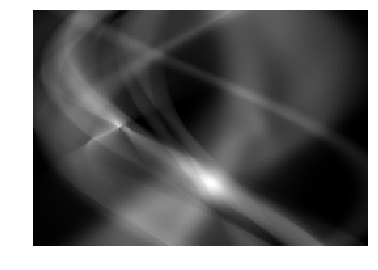

In [28]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram , cmap="gray")

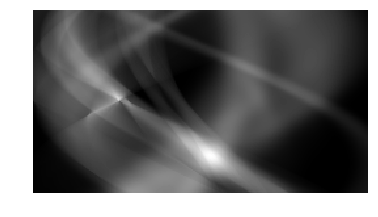

In [29]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram_wedge , cmap="gray")

## Data generation

In [30]:
size = 256
nClasses = 180
lowd = 0
wedge = 20
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [31]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [32]:
def random_phantom_generation_lowd_wedge(size, nClasses, lowd, wedge):
    # Compute first the full dose Wavefront set
    nEllipses = np.random.randint(10,20)
    dirBias = np.random.randint(0,180)
    phantom, _, _,  _ = random_phantom(size, nRegions, npoints_max, 180)
    sinogram = np.array(operator(space.element(phantom)))
    sinogram_wedge= np.array(operator_wedge(space.element(phantom)))
    return phantom, sinogram_wedge, sinogram

In [33]:
def random_realphantom_generation_lowd_wedge(size, nClasses, lowd, wedge):
    # Compute first the full dose Wavefront set
    nRegions = np.random.randint(5,10)
    npoints_max = np.random.randint(8,15)
    realphantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, 180)
    sinogram = np.array(operator(space.element(realphantom)))
    sinogram_wedge= np.array(operator_wedge(space.element(realphantom)))
    return realphantom, sinogram_wedge, sinogram

In [34]:
# Batch generation for training
def generate_realphantom_lowd_wedge(batch_size, size, lowd, wedge):
    n_generate = batch_size

    y_arr = np.empty((n_generate, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')
    
    for i in range(n_generate):
        realphantom, sinogram_wedge, sinogram = random_realphantom_generation_lowd_wedge(size, nClasses, lowd, wedge)
        
        x_true_arr[i, ..., 0] =  realphantom
        y_arr[i, ..., 0] = sinogram_wedge
    return y_arr, x_true_arr

In [35]:
# Batch generation for training
def generate_phantom_lowd_wedge(batch_size, size, lowd, wedge):
    n_generate = batch_size

    y_arr = np.empty((n_generate, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')
    
    for i in range(n_generate):
        phantom, sinogram_wedge, sinogram = random_phantom_generation_lowd_wedge(size, nClasses, lowd, wedge)
        
        x_true_arr[i, ..., 0] =  realphantom
        y_arr[i, ..., 0] = sinogram_wedge
    return y_arr, x_true_arr

In [36]:
def DataGenerator_realphantom_lowd_wedge(batch_size, size, lowd, wedge):
    while True:
        yield generate_realphantom_lowd_wedge(batch_size, size, lowd, wedge)

In [37]:
def DataGenerator_phantom_lowd_wedge(batch_size, size, lowd, wedge):
    while True:
        yield generate_phantom_lowd_wedge(batch_size, size, lowd, wedge)

## PhantomNet

In [38]:
import pyshearlab
import numpy as np

In [39]:
shearletSystem = pyshearlab.SLgetShearletSystem2D(0,size, size, 4)

In [40]:
def getOrientation(shearletSystem):
    shearlevels = shearletSystem["shearLevels"]
    n_shearlets = np.shape(shearletSystem["shearlets"])[2]
    angle = np.zeros((n_shearlets))
    for i in range(0,n_shearlets):
        tmp = shearletSystem["shearletIdxs"][i]
        #first cone
        if tmp[0] ==1:      
            te = tmp[2]/(2**(shearlevels[tmp[1]-1]))
            angle[i] = np.arctan(1/te)/(np.pi)*180
        #cone 2
        elif tmp[0] ==2:
            te = tmp[2]/(2**(shearlevels[tmp[1]-1]))
            angle[i] = np.arctan((-te))/(2*np.pi)*360
        else:
            angle[i] = 0
    return angle%180

In [41]:
angles = getOrientation(shearletSystem)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


### Visualizing angles

In [42]:
phantom, sinogram_wedge, sinogram = random_phantom_generation_lowd_wedge(size, nClasses, lowd, wedge)

In [43]:
coeffs = pyshearlab.SLsheardec2D(phantom, shearletSystem)

In [44]:
shearlets = shearletSystem["shearlets"]
shearletIdxs = shearletSystem["shearletIdxs"]

In [45]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [46]:
j = 4
shearlet = shearlets[:,:,j]
shearlet_space = fftshift(ifft2(ifftshift(shearlets[:,:,j])))
coeff = coeffs[:,:,j]
index = shearletIdxs[j]

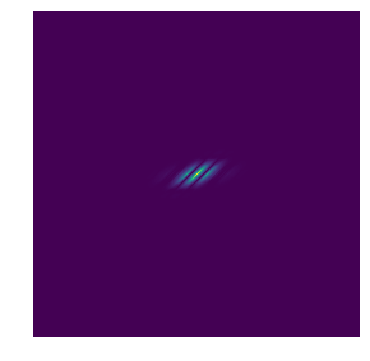

In [47]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(np.abs(shearlet_space))

In [48]:
angles[j], index

(45.0, array([1, 1, 2]))

## Missing angles

In [49]:
missingAngles  = (angles<=wedge)|(angles >= 180-wedge )

In [50]:
visible = coeffs.copy()
visible[:,:,missingAngles] = 0.0

In [51]:
reconstruction_visible = pyshearlab.SLshearrec2D(visible, shearletSystem)
reconstruction_ground_truth = pyshearlab.SLshearrec2D(coeffs, shearletSystem)

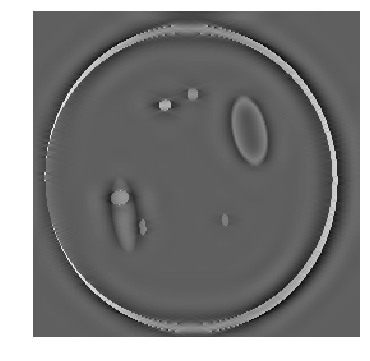

In [52]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(reconstruction_visible, cmap='gray')

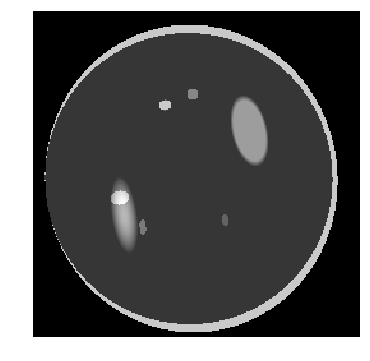

In [53]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(reconstruction_ground_truth, cmap='gray')

## Wedge data generation

In [54]:
def phantom_shear_coeffs_lowd_wedge(size, nClasses, lowd, wedge, shearletSystem):
    # Compute first the full dose Wavefront set
    nEllipses = np.random.randint(10,20)
    dirBias = np.random.randint(0,180)
    phantom, _, _,  _ = random_phantom(size, nRegions, npoints_max, 180)
    coeffs = pyshearlab.SLsheardec2D(phantom, shearletSystem)
    angles = getOrientation(shearletSystem)
    missingAngles = (angles<=wedge)|(angles >= 180-wedge)
    visible = coeffs[:,:,~missingAngles]
    invisible = coeffs[:,:,missingAngles]
    return visible, invisible

In [55]:
def realphantom_shear_coeffs_lowd_wedge(size, nClasses, lowd, wedge, shearletSystem):
    # Compute first the full dose Wavefront set
    nEllipses = np.random.randint(10,20)
    dirBias = np.random.randint(0,180)
    phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, 180)
    coeffs = pyshearlab.SLsheardec2D(phantom, shearletSystem)
    angles = getOrientation(shearletSystem)
    missingAngles = (angles<=wedge)|(angles >= 180-wedge)
    visible = coeffs[:,:,~missingAngles]
    invisible = coeffs[:,:,missingAngles]
    return visible, invisible

In [56]:
# Batch generation for training
def generate_phantom_shear_lowd_wedge(batch_size, size, lowd, wedge, shearletSystem):
    n_generate = batch_size
    angles = getOrientation(shearletSystem)
    missingAngles = (angles<=wedge)|(angles >= 180-wedge)

    y_arr = np.empty((n_generate, space.shape[0], space.shape[1], int(sum(~missingAngles))), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], int(sum(missingAngles))), dtype='float32')
    
    for i in range(n_generate):
        visible, invisible = phantom_shear_coeffs_lowd_wedge(size, nClasses, lowd, wedge, shearletSystem)
        
        x_true_arr[i] =  invisible
        y_arr[i] = visible
    return y_arr, x_true_arr

In [57]:
# Batch generation for training
def generate_realphantom_shear_lowd_wedge(batch_size, size, lowd, wedge, shearletSystem):
    n_generate = batch_size
    angles = getOrientation(shearletSystem)
    missingAngles = (angles<=wedge)|(angles >= 180-wedge)

    y_arr = np.empty((n_generate, space.shape[0], space.shape[1], int(sum(~missingAngles))), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], int(sum(missingAngles))), dtype='float32')
    
    for i in range(n_generate):
        visible, invisible = realphantom_shear_coeffs_lowd_wedge(size, nClasses, lowd, wedge, shearletSystem)
        
        x_true_arr[i] =  invisible
        y_arr[i] = visible
    return y_arr, x_true_arr

In [58]:
def DataGenerator_phantom_shear_lowd_wedge(batch_size, size, lowd, wedge,  shearletSystem):
    while True:
        yield generate_phantom_shear_lowd_wedge(batch_size, size, lowd, wedge, shearletSystem)

In [59]:
def DataGenerator_realphantom_shear_lowd_wedge(batch_size, size, lowd, wedge):
    while True:
        yield generate_realphantom_shear_lowd_wedge(batch_size, size, lowd, wedge, shearletSystem)

## The UNet

In [60]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

In [61]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import losses

In [62]:
def unet2(pretrained_weights = None,input_size =  (size,size,sum(~missingAngles))):
    inputs = Input(input_size)
    print(inputs.shape)
    conv1 = Conv2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(inputs)
    conv1 = Conv2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(pool1)
    conv2 = Conv2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(pool2)
    conv3 = Conv2D(256, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(pool3)
    conv4 = Conv2D(512, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(merge6)
    conv6 = Conv2D(512, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv6)

    up7 = Conv2D(256, 2, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(merge7)
    conv7 = Conv2D(256, 3, activation ='tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv7)

    up8 = Conv2D(128, 2, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer ='glorot_uniform')(merge8)
    conv8 = Conv2D(128, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv8)

    up9 = Conv2D(64, 2, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer ='glorot_uniform')(merge9)
    conv9 = Conv2D(64, 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv9 = Conv2D(sum(missingAngles), 3, activation = 'tanh', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)

    model = Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(lr = 1e-4), loss =l1_and_l2_loss, metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [63]:
def l1_and_l2_loss(y_true,y_pred):
    
    a = losses.mean_squared_error(y_true,y_pred)
    b = losses.mean_absolute_error(y_true,y_pred)
    return a

### Load model

In [64]:
# Tensorflow and seed
seed_value = 0
import random
random.seed(seed_value)
import tensorflow as tf
tf.set_random_seed(seed_value)

# Importing relevant keras modules
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model
from shared.shared import create_increasing_dir
import pickle

In [65]:
# Import model and custom losses
from models.unet import UNet
from models.losses import CUSTOM_OBJECTS

In [66]:
# Parameters for the training
learning_rate = 1e-3
loss = 'mae'
batch_size = 20
epoches = 10000

In [67]:
pretrained = 1
path_to_model_dir = './unet_realphantom_wedge'+str(wedge)+'/training_0'

In [68]:
# Data generator
size = 256
nClasses = 180
lowd = 180
train_gen = DataGenerator_realphantom_shear_lowd_wedge(batch_size, size, lowd, wedge)
val_gen = DataGenerator_realphantom_shear_lowd_wedge(batch_size, size, lowd, wedge)

In [69]:
CUSTOM_OBJECTS = {
    #'my_mean_squared_error': my_mean_squared_error,
    'l1_and_l2_loss': l1_and_l2_loss,
    # if really a wedge should be used then there is a problem here.
    # Bcz the wedge is not accessible in this file, but the CUSTOM_OBJECTS
    # is not accessible in unet.py. A solution might be to really serialize
    # the CUSTOM_OBJECTS
    #l2_on_wedge': l2_on_wedge_factory(None),
    #'my_psnr': my_psnr
}

In [70]:
if pretrained==0:
    # Create a fresh model
    print("Create a fresh model")
    model = unet2()
    path_to_training = create_increasing_dir('./unet_realphantom_wedge'+str(wedge), 'training')
    print("Save training in {}".format(path_to_training))
    path_to_model_dir = path_to_training
    
else: 
    print("Use trained model as initialization:")
    print(path_to_model_dir+"/weights.hdf5")
    model = load_model(path_to_model_dir+"/weights.hdf5",
                       custom_objects=CUSTOM_OBJECTS)
    path_to_training = path_to_model_dir

Use trained model as initialization:
./unet_realphantom_wedge20/training_0/weights.hdf5


In [71]:
# Callbacks for saving model
context = {
    "loss": loss,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "path_to_model_dir": path_to_model_dir,
}
path_to_context = path_to_training+'/context.log'

with open(path_to_context, 'wb') as dict_items_save:
    pickle.dump(context, dict_items_save)
print("Save training context to {}".format(path_to_context))

# Save architecture
model_json = model.to_json()
path_to_architecture = path_to_training + "/model.json"
with open(path_to_architecture, "w") as json_file:
    json_file.write(model_json)
print("Save model architecture to {}".format(path_to_architecture))

# Checkpoint for trained model
checkpoint = ModelCheckpoint(
    path_to_training+'/weights.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True)
csv_logger = CSVLogger(path_to_training+'/training.log')

callbacks_list = [checkpoint, csv_logger]

Save training context to ./unet_realphantom_wedge20/training_0/context.log
Save model architecture to ./unet_realphantom_wedge20/training_0/model.json


In [72]:
batch_size = 1

In [73]:
y_arr, x_true_arr = generate_phantom_shear_lowd_wedge(batch_size, size, lowd, wedge, shearletSystem)

/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


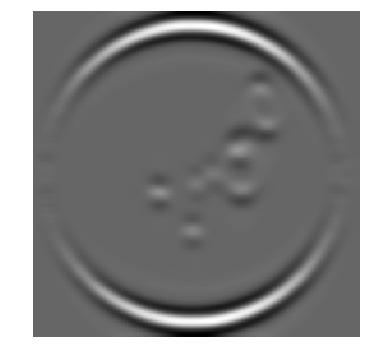

In [74]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

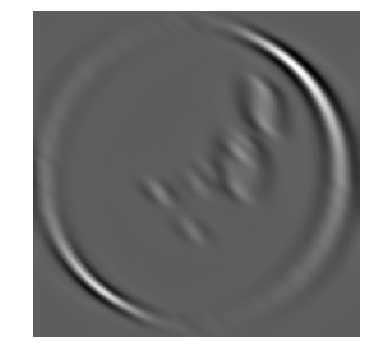

In [75]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(y_arr[0,:,:,0], cmap="gray")

In [76]:
X_predict_val = model.predict(y_arr);

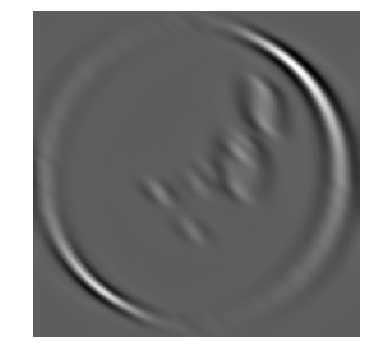

In [77]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(y_arr[0,:,:,0], cmap="gray")

In [78]:
visible = y_arr[0,:,:,:]
invisible = x_true_arr[0,:,:,:]

In [79]:
invisible_predict = X_predict_val[0,:,:,:]

In [80]:
lima = np.zeros(coeffs.shape)
lima[:,:,~missingAngles] = visible

In [81]:
predict = ground_truth = lima.copy()

In [82]:
ground_truth[:,:,missingAngles] = x_true_arr[0,:,:,:]

In [83]:
predict[:,:,missingAngles] = invisible_predict 

In [84]:
lim_recon = pyshearlab.SLshearrec2D(lima, shearletSystem)
ground_truth_recon = pyshearlab.SLshearrec2D(ground_truth, shearletSystem)
predict_recon = pyshearlab.SLshearrec2D(predict, shearletSystem)

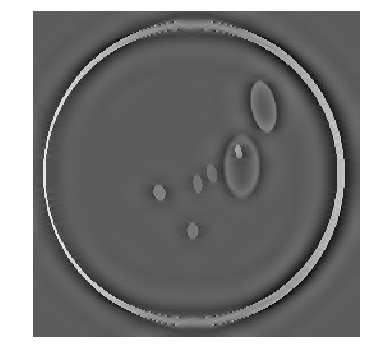

In [85]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lim_recon, cmap="gray")

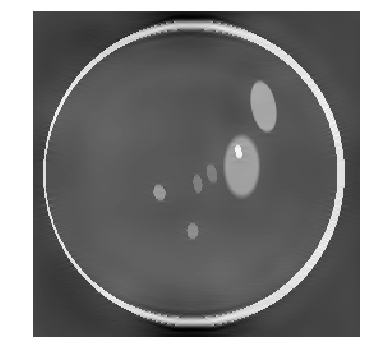

In [86]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(ground_truth_recon, cmap="gray")

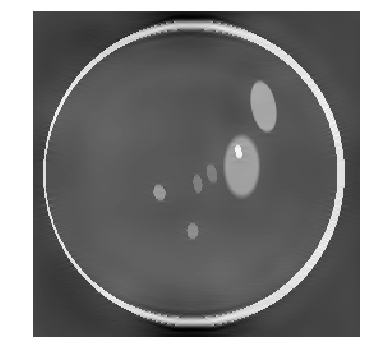

In [87]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(predict_recon, cmap="gray")

## Brain

In [88]:
from PIL import Image
from skimage import data
from skimage.transform import resize

In [91]:
brain = np.array(Image.open('../brain.png'))[:,:,0].astype(np.float)
brain = resize(brain, (size,size))/brain.max()

In [93]:
coeffs_brain = pyshearlab.SLsheardec2D(brain, shearletSystem)
visible_brain = coeffs_brain[:,:,~missingAngles]
invisible_brain = coeffs_brain[:,:,~missingAngles]

In [94]:
brain_predict = model.predict(visible_brain[np.newaxis,:,:,:]);

In [95]:
lima_brain = np.zeros(coeffs.shape)
lima_brain[:,:,~missingAngles] = visible_brain

In [96]:
predict_brain = lima_brain.copy()

In [97]:
predict_brain[:,:,missingAngles] = brain_predict[0]

In [98]:
lim_brain_recon = pyshearlab.SLshearrec2D(lima_brain, shearletSystem)
ground_truth_brain_recon = pyshearlab.SLshearrec2D(coeffs_brain, shearletSystem)
predict_brain_recon = pyshearlab.SLshearrec2D(predict_brain, shearletSystem)

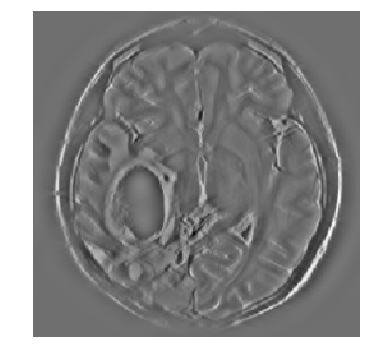

In [101]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(lim_brain_recon, cmap="gray")

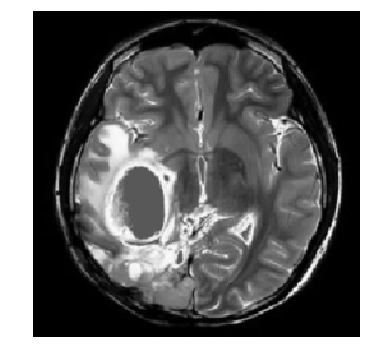

In [104]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(ground_truth_brain_recon, cmap="gray")

### Inpainting from sparse reconstruction

In [105]:
phantom = ground_truth_brain_recon
sinogram_wedge_odl = operator_wedge(space.element(phantom))

In [106]:
# Assemble all operators into a list.
grad = odl.Gradient(space)
lin_ops_wedge = [operator_wedge, grad]
a = 0.001

In [107]:
# Create functionals for the l2 distance and l1 norm.
g_funcs_wedge = [odl.solvers.L2NormSquared(operator_wedge.range).translated(sinogram_wedge_odl),
           a * odl.solvers.L1Norm(grad.range)]

In [108]:
f_wedge = odl.solvers.IndicatorBox(space, 0, 1)

In [109]:
opnorm_wedge = odl.power_method_opnorm(operator_wedge)
opnorm_grad = odl.power_method_opnorm(grad)

In [110]:
sigma_wedge = [1 / opnorm_wedge ** 2, 1 / opnorm_grad ** 2]

tau = 1.0
phantom_tv_wedge = space.zero()

In [111]:
odl.solvers.douglas_rachford_pd(phantom_tv_wedge, f_wedge, g_funcs_wedge, lin_ops_wedge,
                                tau=tau, sigma=sigma_wedge, niter=200)

In [112]:
phantom_tv_wedge = np.array(phantom_tv_wedge)

In [113]:
coeffs_brain = pyshearlab.SLsheardec2D(phantom_tv_wedge, shearletSystem)
visible_brain = coeffs_brain[:,:,~missingAngles]
invisible_brain = coeffs_brain[:,:,missingAngles]

In [114]:
visible_brain = pyshearlab.SLsheardec2D(phantom, shearletSystem)[:,:,~missingAngles]

In [115]:
brain_predict = model.predict(visible_brain[np.newaxis,:,:,:]);

In [116]:
lima_brain = np.zeros(coeffs.shape)
lima_brain[:,:,~missingAngles] = visible_brain

In [117]:
predict_brain = lima_brain.copy()

In [118]:
predict_brain[:,:,missingAngles] = brain_predict[0]

In [119]:
lim_brain_recon = pyshearlab.SLshearrec2D(lima_brain, shearletSystem)
ground_truth_brain_recon = pyshearlab.SLshearrec2D(coeffs_brain, shearletSystem)
predict_brain_recon = pyshearlab.SLshearrec2D(predict_brain, shearletSystem)

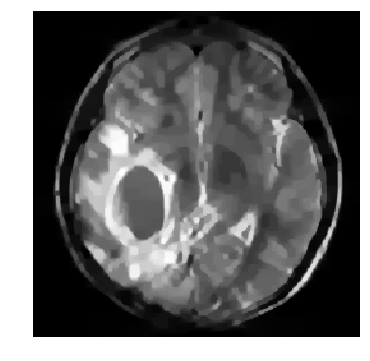

In [125]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(phantom_tv_wedge, cmap="gray")
plt.savefig('../results_realdata/brain-recon-phantomnet_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [127]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
import sys

In [130]:
print("SSIM: ", ssim(phantom_tv_wedge,phantom))
print("PSNR: ", psnr(phantom_tv_wedge,phantom, data_range=1))

SSIM:  0.872450279288
PSNR:  25.4921051432


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


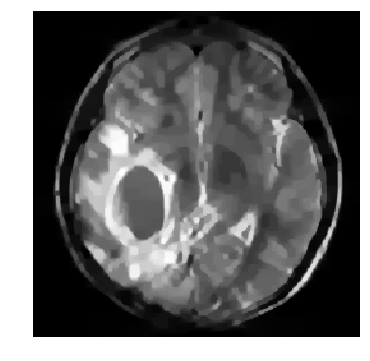

In [122]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(ground_truth_brain_recon, cmap="gray")

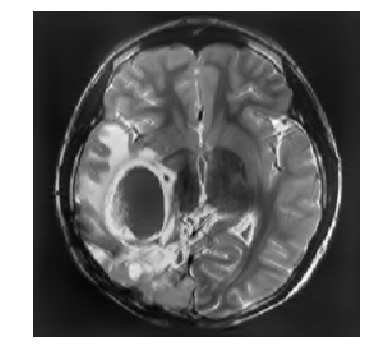

In [123]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(predict_brain_recon, cmap="gray")
#plt.savefig('../results_benchmarks/shepp-loggan-recon-fbp_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

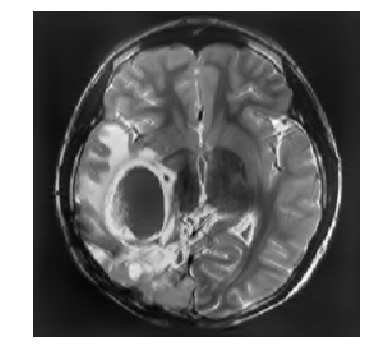

In [124]:
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(predict_brain_recon, cmap="gray")